# Testing single-particle wave functions

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ November 17, 2022

This notebook serves as a testbed for single-particle wave functions from a Wood-Saxon potential, and the SLy4 Skyrme functional using the `HFBRAD` code. The single-particle wave functions are inputs to the spectroscopic overlap $\langle \Psi_\alpha^{A-1} \lvert a_{\mathbf{q}} \rvert \Psi_0^A \rangle$.

_Last update:_ November 29, 2022

### Run `f2py` on the Wood-Saxon subroutine

In [1]:
# %%bash
# cd scripts
# python -m numpy.f2py -c woodsaxon.f90 -m woodsaxon
# cd ../

__To-do list:__
* Organize single-particle states better. Should not be considering unbound states.
* Generalize `plot_sp_wfs_rspace` to neutron wave functions for isospin asymmetric nuclei.

__Questions about Wood-Saxon code:__
* Where can I find the parameters for the potential `prm` and what are the "best" settings?
* Can you sort by the energy of the state and determine many states up some cutoff?

In [2]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import interp1d
from scipy.special import spherical_jn

In [3]:
# Imports from scripts
from scripts.figures import set_rc_parameters, label_nlj_state, label_nucleus
from scripts.integration import momentum_mesh
from scripts.tools import replace_periods
from scripts.woodsaxon import ws

### Set-up

In [4]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [5]:
# Save figures in the following directory
figures_directory = '../figures/spectroscopic_factors/'

In [6]:
class SingleParticleBasis:
    """
    Wood-Saxon single-particle basis class. Handles the wave functions
    associated with the Wood-Saxon potential from the subroutine in
    woodsaxon.f90. Generates wave functions in coordinate and momentum space.
    
    Parameters
    ----------
    nucleus_name : str
        Name of the nucleus (e.g., 'O16', 'Ca40', etc.)
    Z : int
        Proton number of the nucleus.
    N : int
        Neutron number of the nucleus.
    n_max : int
        Maximum principal quantum number where n = 1, 2, ..., n_max.
    l_max : int
        Maximum orbital angular momentum where l = 0, 1, ..., l_max.
    ntau : int, optional
        Type of orbitals: 1 - nucleons with no Coulomb
                          2 - distinguish protons and neutrons
    rmax : float, optional
        Maximum r for orbital tables.
    ntab : int, optional
        Number of points for orbital tables.
    prnt : bool, optional
        Option to print summary, potentials, and densities.
    prntorb : bool, optional
        Option to print orbital tables.
        
    """
    
    
    def __init__(
            self, nucleus_name, Z, N, n_max, l_max, ntau=1, rmax=40, ntab=2000,
            prnt=False, prntorb=False):
        """Run Wood-Saxon code and set instance attributes."""
        
        # Total number of nucleons
        A = Z + N
        
        # Orbitals to consider (note, we track 2*j not j)
        norb, lorb, jorb = [], [], []
        for n in range(1, n_max+1):
            for l in range(0, l_max+1):
                norb.append(n)
                lorb.append(l)
                jorb.append(int(2*(l+1/2)))
                if int(2*(l-1/2)) > 0:  # Don't append negative j
                    norb.append(n)
                    lorb.append(l)
                    jorb.append(int(2*(l-1/2)))
        nrad = len(jorb)
        orbws = np.zeros(shape=(2,nrad,ntab), order='F')
    
        # Divide orbital by r? -> get R(r); false: get u(r)=r R(r)
        rdiv = False
        dens = True
    
        # Set parameters of the Wood-Saxon potential
        prm = np.zeros(shape=(2,9), order='F')
    
        # Starting with vws (p & n)
        if nucleus_name == 'He4':
            prm[:,0] = 76.8412
        elif nucleus_name == 'O16':
            prm[:,0] = 58.0611
        elif nucleus_name == 'Ca40':
            prm[:,0] = 54.3051
        elif nucleus_name == 'Ca48':
            prm[0,0] = 59.4522
            prm[1,0] = 46.9322
    
        # Not sure about these (better way to load these parameters?)
        prm[:,1] = 1.275
        prm[:,2] = 0.7
        prm[:,3] = 0.
        prm[:,4] = 1.
        prm[:,5] = 36
        prm[:,6] = 1.32
        prm[:,7] = 0.7
        prm[:,8] = 1.275

        # Run Fortran subroutine
        ws(ntau, A, Z, rmax, orbws, norb, lorb, jorb, prm, rdiv, prnt, prntorb,
           dens)
    
        orbws_python = np.transpose(orbws)
        
        # Store data in dictionary
        self.sp_wfs = {}
        for i, (n, l, j) in enumerate(zip(norb, lorb, jorb)):
            self.sp_wfs[(n,l,j/2,1/2)] = orbws_python[:,i,0]
            self.sp_wfs[(n,l,j/2,-1/2)] = orbws_python[:,i,1]

        # Set radial distance array and step-size as instance attributes
        self.dr = rmax / ntab
        self.r_array = np.arange(self.dr, rmax + self.dr, self.dr)
    
    
    def get_wf_rspace(self, n, l, j, tau, print_normalization=False):
        """Single-particle wave function in coordinate space."""
        
        u_array = self.sp_wfs[(n, l, j, tau)]

        # Normalization: \int dr |u(r)|^2 = 1
        if print_normalization:
            normalization = np.sum(self.dr*u_array**2)
            print(f"Coordinate space normalization = {normalization}.")

        return self.r_array, u_array
    
    
    def fourier_transformation(self, l, k_array):
        """Fourier transformation matrix for given orbital angular momentum."""
        
        # r_array column vectors and k_array row vectors where both grids are
        # n x m matrices
        r_cols, k_rows = np.meshgrid(self.r_array, k_array)
        
        # Transformation matrix with shape n x m, where m is the length of
        # r_array and n is the length of the k_array
        M = np.sqrt(2/np.pi) * self.dr * r_cols * spherical_jn(l, k_rows*r_cols)
        ### TESTING
        # M = (-1j)**l * np.sqrt(2/np.pi) * self.dr * r_cols * spherical_jn(l, k_rows*r_cols)
        
        return M
    
    
    def get_wf_kspace(
            self, n, l, j, tau, print_normalization=False, interpolate=False,
            kmax=15.0, kmid=3.0, ntot=120):
        """Single-particle wave function in momentum space."""
    
        # Set momentum mesh
        k_array, k_weights = momentum_mesh(kmax, kmid, ntot)
    
        # Get coordinate-space s.p. wave function
        _, u_array = self.get_wf_rspace(n, l, j, tau)

        # Fourier-transform the wave function to momentum space
        phi_array = self.fourier_transformation(l, k_array) @ u_array
    
        # Normalization: \int dk k^2 |\phi(k)|^2 = 1
        if print_normalization:
            normalization = np.sum(k_weights*k_array**2*phi_array**2)
            print(f"Momentum space normalization = {normalization}.")
            
        # Interpolate and return function?
        if interpolate:
            phi_func = interp1d(k_array, phi_array, kind='linear',
                                bounds_error=False, fill_value='extrapolate')
            return phi_func
        
        # Otherwise return momentum, weights, and \phi(k)
        else:
            return k_array, k_weights, phi_array

In [7]:
# might not need the functions below
    
#     def get_sp_str(self, n, l, j):
#         pass
    
#     def get_sp_quantum_numbers(self, sp_str):
#         pass
    
#     def get_nucleon(self, tau):
#         pass
    
#     def get_tau(self, nucleon):
#         pass

## Single-particle wave functions in coordinate space

In [8]:
def plot_sp_wfs_rspace(nucleus_name, Z, N, n_max, l_max, x_limits=(0.0,10.0),
                       y_limits=(0.0,0.8), save=False):
    """Plot the s.p. wave functions of a nucleus in coordinate space."""
    
    spb = SingleParticleBasis(nucleus_name, Z, N, n_max, l_max)

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    # Loop over quantum numbers (keys in dictionary) and add s.p. wave function
    # to the figure
    for key in spb.sp_wfs:
        
        n, l, j, tau = key

        # Plot proton wave function only
        if tau == 1/2:
                
            r_array, u_array = spb.get_wf_rspace(n, l, j, tau)
                
            ax.plot(r_array, u_array, label=label_nlj_state(n, l, j),
                    linewidth=2.0)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$r$ [fm]", fontsize=16)
    ax.set_ylabel(r"proton $u(r)$ [fm" + r'$^{-1/2}$' + ']', fontsize=16)

    # Set legend
    if len(spb.sp_wfs)/2 <= 3:
        ax.legend(loc='upper right', fontsize=14, frameon=False)
    else:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0,
                  fontsize=12)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='lower right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = f'{nucleus_name}_sp_wfs_rspace.png'
        f.savefig(figures_directory + file_name)

In [9]:
nucleus_name, Z, N = 'He4', 2, 2
n_max = 1
l_max = 1
spb = SingleParticleBasis(nucleus_name, Z, N, n_max, l_max)
# spb = SingleParticleBasis(nucleus_name, Z, N, n_max, l_max, prnt=True)

In [10]:
r_array, u_array = spb.get_wf_rspace(1, 0, 1/2, 1/2, print_normalization=True)

Coordinate space normalization = 1.0000000000008629.


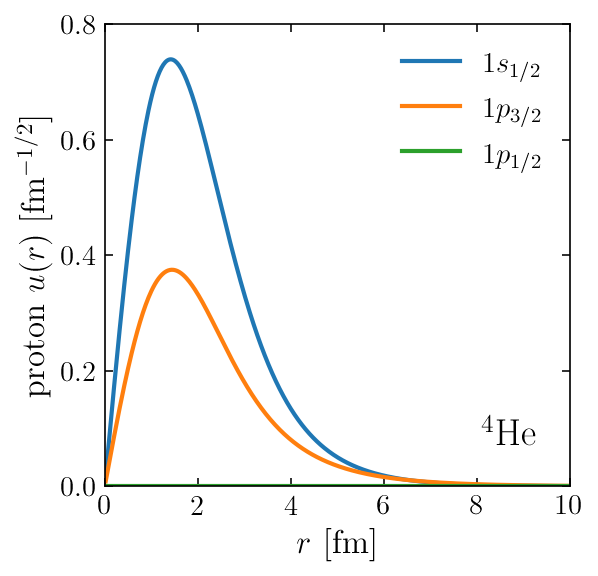

In [11]:
plot_sp_wfs_rspace(nucleus_name, Z, N, n_max, l_max, save=True)

The Wood-Saxon code gives two states that are bound ($E<0$). The other states say $E=0$ in the file `ws_log`.

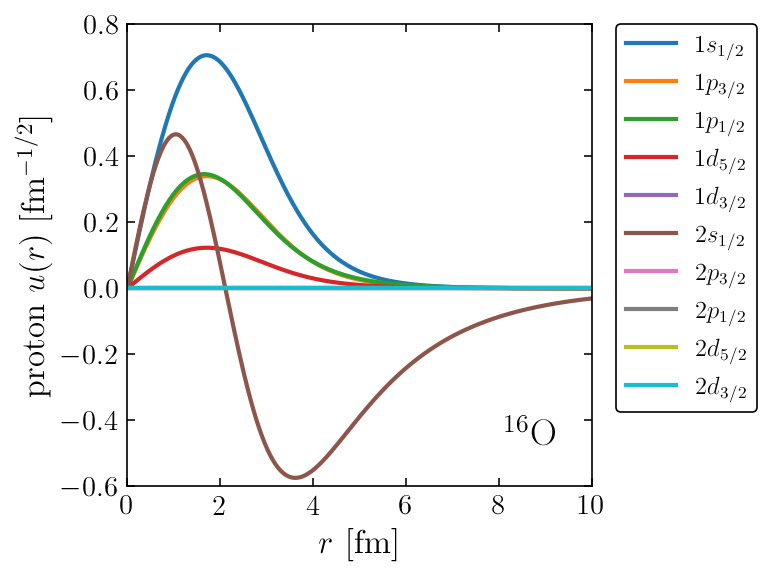

In [20]:
plot_sp_wfs_rspace('O16', 8, 8, 2, 2, y_limits=(-0.6,0.8), save=True)

## Single-particle wave functions in momentum space

In [13]:
def plot_sp_wfs_kspace(nucleus_name, Z, N, n_max, l_max, x_limits=(0.0,5.0),
                       y_limits=(-0.1,4.0), save=False):
    """Plot the s.p. wave functions of a nucleus in momentum space."""
    
    spb = SingleParticleBasis(nucleus_name, Z, N, n_max, l_max)

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    # Loop over quantum numbers (keys in dictionary) and add s.p. wave function
    # to the figure
    for key in spb.sp_wfs:
        
        n, l, j, tau = key

        # Plot proton wave function only
        if tau == 1/2:
                
            k_array, _, phi_array = spb.get_wf_kspace(n, l, j, tau)
                
            ax.plot(k_array, phi_array, label=label_nlj_state(n, l, j),
                    linewidth=2.0)

    # Add horizontal line at y=0
    ax.axhline(0.0, color='gray', alpha=0.4, zorder=1)
        
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$k$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"proton $\phi(k)$ [fm" + r'$^{3/2}$' + ']', fontsize=16)

    # Set legend
    if len(spb.sp_wfs)/2 <= 3:
        ax.legend(loc='upper right', fontsize=14, frameon=False)
    else:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.0,
                  fontsize=12)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = f'{nucleus_name}_sp_wfs_kspace_SLy4.png'
        f.savefig(figures_directory + file_name)

In [14]:
k_array, k_weights, phi_array = spb.get_wf_kspace(1, 0, 1/2, 1/2,
                                                  print_normalization=True)

Momentum space normalization = 1.0000000000006437.


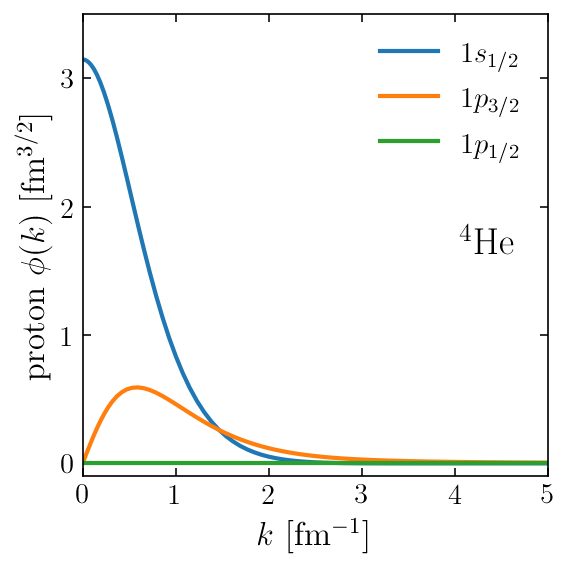

In [15]:
plot_sp_wfs_kspace(nucleus_name, Z, N, n_max, l_max, y_limits=(-0.1,3.5),
                   save=True)

## Comparison of $^{4}$He proton $1s_{1/2}$ wave function from SLy4 and Wood-Saxon potential

In [16]:
def get_sly4_rspace(nucleus_name, Z, N, nucleon, sp_state,
                    print_normalization=False):
    """SLy4 single-particle wave functions in coordinate space."""
    
    if nucleon == 'proton':
        nuc_int = 1
    elif nucleon == 'neutron':
        nuc_int = 0
    
    hfbrad_directory = '../data/dft/SLy4/'
    file_name = f'{nucleon}_{sp_state}_{N}_{Z}.gfx'
    
    data = np.loadtxt(hfbrad_directory + f"{nucleus_name}/wfs/{file_name}")

    r_array = data[:, 0]  # Units fm
    dr = r_array[1] - r_array[0]  # Linear spacing between r points
    u_array = data[:, 2]  # Units fm^-1/2
    
    # These are normalized as \int dr |u(r)|^2 = 1
    if print_normalization:
        print(f"Coordinate space normalization = {np.sum(dr*u_array**2)}.")
    
    return r_array, u_array

In [17]:
def compare_sp_wf_rspace(x_limits=(0.0,10.0), y_limits=(0.0,0.8), save=False):
    """Compare SLy4 and Wood-Saxon single-particle wave functions."""

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    # Get the data
    nucleus_name, Z, N = 'He4', 2, 2
    n, l, j, tau = 1, 0, 1/2, 1/2
    
    # Plot just the 1s_{1/2} proton wave function for He4
    # SLy4
    r_sly4_array, u_sly4_array = get_sly4_rspace(nucleus_name, Z, N, 'proton',
                                                '1s0p5')
    # Wood-Saxon
    spb = SingleParticleBasis(nucleus_name, Z, N, n, l)
    r_ws_array, u_ws_array = spb.get_wf_rspace(n, l, j, tau)
    
    # Add both to the figure
    ax.plot(r_sly4_array, u_sly4_array, label='SLy4', linewidth=2.0)
    ax.plot(r_ws_array, u_ws_array, label='Wood-Saxon', linewidth=2.0)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$r$ [fm]", fontsize=16)
    ax.set_ylabel(r"proton $u(r)$ [fm" + r'$^{-1/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='lower right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add s.p. state label
    ax.add_artist(
        AnchoredText(label_nlj_state(n, l, j), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = f'{nucleus_name}_compare_sp_wf_rspace.png'
        f.savefig(figures_directory + file_name)

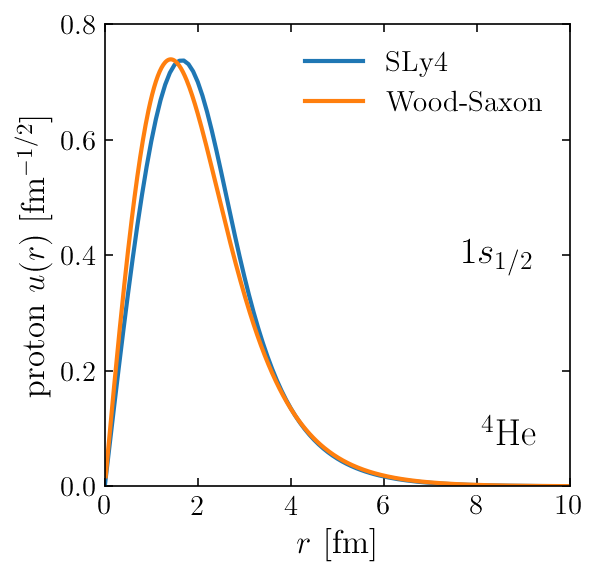

In [18]:
compare_sp_wf_rspace(save=True)